In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

2024-10-01 22:10:23.968087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 22:10:25.978309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load MNIST

In [2]:
def load_mnist_dataset(val_ratio=0.1, num_train=500, num_val=500, num_test=50):
    """MNIST Dataloader with offset added(for background class inclusion)"""
    # Load MNIST dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize pixel values to be between 0 and 1
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Offset labels by 1 to reserve 0 for the background class
    y_train = y_train + 1
    y_test = y_test + 1

    # Split the original train set into new train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio)

    # Take only the required number of samples for each dataset
    x_train, y_train = x_train[:num_train], y_train[:num_train]
    x_val, y_val = x_val[:num_val], y_val[:num_val]
    x_test, y_test = x_test[:num_test], y_test[:num_test]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Load datasets with the specified number of samples
train_ds, val_ds, test_ds = load_mnist_dataset()

# Print the number of images in each dataset
# print(f"Images in train_ds: {len(train_ds[0])}")
print(f"Images in val_ds: {len(val_ds[0])}")
# print(f"Images in test_ds: {len(test_ds[0])}")

Images in val_ds: 500


# Coordinate formats converter functions

In [3]:
def center2yx(boxes):
    """
    Convert bounding boxes from center format (cx, cy, w, h) 
    to corner format (ymin, xmin, ymax, xmax).
    
    Args:
    - boxes: A TensorFlow tensor of shape (..., 4) where
             each box is of the format (cx, cy, w, h).
    
    Returns:
    - A TensorFlow tensor of the same shape containing
      bounding boxes in the format (ymin, xmin, ymax, xmax).
    """
    cx, cy, w, h = tf.split(boxes, num_or_size_splits=4, axis=-1)
    xmin = cx - (w * 0.5)
    xmax = cx + (w * 0.5)
    ymin = cy - (h * 0.5)
    ymax = cy + (h * 0.5)
    return tf.concat([ymin, xmin, ymax, xmax], axis=-1)

def yx2center(boxes):
    """
    Convert bounding boxes from corner format (ymin, xmin, ymax, xmax)
    to center format (cx, cy, w, h).
    
    Args:
    - boxes: A TensorFlow tensor of shape (..., 4) where
             each box is of the format (ymin, xmin, ymax, xmax).
    
    Returns:
    - A TensorFlow tensor of the same shape containing
      bounding boxes in the format (cx, cy, w, h).
    """
    ymin, xmin, ymax, xmax = tf.split(boxes, num_or_size_splits=4, axis=-1)
    cx = (xmin + xmax) / 2
    cy = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return tf.concat([cx, cy, w, h], axis=-1)

# Test with sample data
test_center_coords = np.array([[28, 28, 12, 12]], dtype=np.float32)

# Convert to TensorFlow tensor
test_center_tensor = tf.convert_to_tensor(test_center_coords)

# Example usage
corner_format = center2yx(test_center_tensor)
center_format = yx2center(corner_format)
corner_2 = center2yx(center_format)
center_2 = yx2center(corner_2)

# Print results
print("Corner(ymin, xmin, ymax, xmax) format from center coordinates:", corner_format.numpy())
print("Center(cx, cy, w, h) format from corner coordinates:", center_format.numpy())
print("Corner(ymin, xmin, ymax, xmax) format from re-converted center coordinates:", corner_2.numpy())
print("Center(cx, cy, w, h) format from corner coordinates:", center_2.numpy())

Corner(ymin, xmin, ymax, xmax) format from center coordinates: [[22. 22. 34. 34.]]
Center(cx, cy, w, h) format from corner coordinates: [[28. 28. 12. 12.]]
Corner(ymin, xmin, ymax, xmax) format from re-converted center coordinates: [[22. 22. 34. 34.]]
Center(cx, cy, w, h) format from corner coordinates: [[28. 28. 12. 12.]]


### Load pre-calculated anchor boxes

In [4]:
def denormalize_boxes(boxes, img_size = 224):
    """Denormalize boxes to image size.

    Args:
        boxes: Tensor of shape [num_boxes, 4] with (cx, cy, w, h) format in [0, 1] range.
        img_size: The size of the input image (e.g., 224).

    Returns:
        Denormalized boxes with (cx, cy, w, h) relative to img_size.
    """
    img_size = tf.cast(img_size, tf.float32)
    denormalized_boxes = boxes * img_size
    
    return denormalized_boxes

def load_anchors_as_tensor(file_path, img_size = 224):
    """
    Load anchor boxes from a file and process them.
    
    Args:
    - file_path: Path to the anchors file.
    
    Returns:
    - A tensor of shape (num_anchors, 4) with clipped anchor boxes cx,cy,w,h format.
    """
    # Load anchor boxes from file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Convert each line to a list of floats and clip the values to be within image limits
    anchors = []
    for line in lines:
        cx, cy, w, h = map(float, line.strip().split())
        anchors.append([cx * img_size, cy * img_size, w * img_size, h * img_size])

    # Convert to tensor
    anchors_tensor = tf.convert_to_tensor(anchors, dtype=tf.float32)
    return tf.clip_by_value(anchors_tensor, clip_value_min=0, clip_value_max=img_size)

load_anchors_as_tensor('anchors.txt')

<tf.Tensor: shape=(5250, 4), dtype=float32, numpy=
array([[  4.0096,   4.0096,  22.4   ,  22.4   ],
       [  4.0096,   4.0096,  43.6576,  43.6576],
       [  4.0096,   4.0096,  20.0256,  25.0432],
       ...,
       [112.    , 112.    , 224.    , 224.    ],
       [112.    , 112.    , 224.    , 224.    ],
       [112.    , 112.    , 224.    , 224.    ]], dtype=float32)>

### Compute the IoU (Intersection-over-Union) map between ground_truths and anchor boxes

In [5]:
def compute_iou_map(anchors, ground_truths):
    """
    Compute the Intersection over Union (IoU) map between anchors and ground truth boxes.
    
    Args:
    - anchors: Tensor of shape (num_anchors, 4) with anchor boxes in cx,cy,w,h format.
    - ground_truths: Tensor of shape (num_gt, 4) with ground truth boxes in cx,cy,w,h format.
    
    Returns:
    - A Tensor of shape (num_anchors, num_gt) representing the IoU between each anchor and each ground truth box.
    """
    # Convert anchors and ground truths to corner format (ymin, xmin, ymax, xmax)
    anchors_corner = center2yx(anchors)
    ground_truths_corner = center2yx(ground_truths)
    
    # Unstack the coordinates of anchors and ground truths
    ymin_a, xmin_a, ymax_a, xmax_a = tf.unstack(anchors_corner, axis=-1)
    ymin_gt, xmin_gt, ymax_gt, xmax_gt = tf.unstack(ground_truths_corner, axis=-1)

    # Calculate intersection areas (shape: num_anchors, num_gt_boxes)
    inter_ymin = tf.maximum(ymin_a[:, tf.newaxis], ymin_gt[tf.newaxis, :])
    inter_xmin = tf.maximum(xmin_a[:, tf.newaxis], xmin_gt[tf.newaxis, :])
    inter_ymax = tf.minimum(ymax_a[:, tf.newaxis], ymax_gt[tf.newaxis, :])
    inter_xmax = tf.minimum(xmax_a[:, tf.newaxis], xmax_gt[tf.newaxis, :])
    
    inter_area = tf.maximum(0.0, inter_ymax - inter_ymin) * tf.maximum(0.0, inter_xmax - inter_xmin)

    # Calculate areas of anchor and ground truth boxes
    anchor_area = (ymax_a - ymin_a) * (xmax_a - xmin_a)
    gt_area = (ymax_gt - ymin_gt) * (xmax_gt - xmin_gt)

    # Calculate union area
    union_area = anchor_area[:, tf.newaxis] + gt_area[tf.newaxis, :] - inter_area

    # Compute IoU
    iou = tf.where(union_area > 0, inter_area / union_area, tf.zeros_like(inter_area))

    return iou

# Convert MNIST function to Object Detection Dataset

In [11]:
def mnist_corners_to_center(top_corner_coords, image_size=224, mnist_digit_size=28):
  """
    Convert top-left corner coordinates to center format (cx, cy, w, h).
    
    Args:
    - top_corner_coords: Array of shape (num_images, 2) containing the top-left (x1, y1) coordinates.
    - image_size: The size of the canvas (both width and height).
    - mnist_digit_size: The size of each MNIST digit (typically 28x28).

    Returns:
    - gt_boxes: Tensor of shape (num_images, 4) in (cx, cy, w, h) format.
  """
  # Get x1,y1 coordinates (in pixels, not normalized)
  x1 = top_corner_coords[:, 0]
  y1 = top_corner_coords[:, 1]

  # Compute center coordinates in pixel space
  cx = x1 + (mnist_digit_size / 2)
  cy = y1 + (mnist_digit_size / 2)
  w = np.full_like(cx, mnist_digit_size)  # Width is the size of the MNIST digit
  h = np.full_like(cy, mnist_digit_size)  # Height is also the size of the MNIST digit

  # Stack the results into (cx, cy, w, h) format
  gt_boxes = np.stack([cx, cy, w, h], axis=-1)
  gt_boxes = tf.convert_to_tensor(gt_boxes, dtype=tf.float32)

  return tf.clip_by_value(gt_boxes, clip_value_min=0.0, clip_value_max=image_size)

def encode_boxes_tf(anchor_boxes, gt_boxes, iou_threshold=0.5):
    """Encode anchor boxes with ground truth boxes based on IoU using TensorFlow.
    
    This will compute the IoU map, and calculate encoded offsets for all ground truth
    boxes that have overlap with IoU > 0.5 with some anchor. A positive box index is appended
    after the offsets to indicate wether an encoded offset refers to a negative(0) or positive(1)
    box.

    Returns:
      encoded_boxes: Tensor of shape [num_anchors, num_gt_boxes, 5]
    """

    # Compute IoU matrix: shape [num_anchors, num_gt_boxes]
    iou_matrix = compute_iou_map(anchor_boxes, gt_boxes)

    # Create mask where IoU > threshold
    mask = tf.cast(iou_matrix > iou_threshold, tf.float32)  # Shape: [num_anchors, num_gt_boxes]

    # Prepare shapes
    anchor_boxes_expanded = tf.expand_dims(anchor_boxes, axis=1)  # Shape: [num_anchors, 1, 4]
    gt_boxes_expanded = tf.expand_dims(gt_boxes, axis=0)        # Shape: [1, num_gt_boxes, 4]

    # Compute encoded boxes
    dx = gt_boxes_expanded[..., 0] - anchor_boxes_expanded[..., 0]
    dy = gt_boxes_expanded[..., 1] - anchor_boxes_expanded[..., 1]
    dw = gt_boxes_expanded[..., 2] - anchor_boxes_expanded[..., 2]
    dh = gt_boxes_expanded[..., 3] - anchor_boxes_expanded[..., 3]
    pos = tf.ones_like(dx)

    # Stack encoded values
    encoded = tf.stack([dx, dy, dw, dh, pos], axis=-1)  # Shape: [num_anchors, num_gt_boxes, 5]

    # Apply mask to encoded boxes to zero-out negatives
    encoded_boxes = encoded * tf.expand_dims(mask, axis=-1)  # Shape: [num_anchors, num_gt_boxes, 5]

    # Reshape to [num_gt_boxes, num_anchors, 5]
    encoded_boxes = tf.transpose(encoded_boxes, perm=[1, 0, 2])

    return encoded_boxes

def mnist_convert(x, y, image_size = 224, anchors_path = 'anchors.txt'):
  """Convert MNIST Dataset to Object Detection ready dataset
  
  Arguments:
    x: Images np.array
    y: Class labels array
    image_size: The target size for the images tensor.
    anchors_path: Path to the anchor boxes (cx,cy,w,h) file.
  """
  # We will randomly place the digits on a black canvas.
  # Create a 2D array of top left corners for the mnist image 
  # to be placed.
  mnist_img_dim = x.shape[-1]
  top_corners = np.random.randint(image_size - mnist_img_dim, size=(x.shape[0],2))

  # Asserting that the MNIST images will not go out of the canvas bounds
  assert np.all(top_corners[:, 0] >= 0), "top_left_x is out of bounds (less than 0)"
  assert np.all(top_corners[:, 1] >= 0), "top_left_y is out of bounds (less than 0)"
  assert np.all(top_corners[:, 0] + mnist_img_dim <= image_size), "MNIST image exceeds canvas width"
  assert np.all(top_corners[:, 1] + mnist_img_dim <= image_size), "MNIST image exceeds canvas height"

  max_corner_value = image_size - mnist_img_dim  # 224 - 28 = 196
  assert np.all(top_corners[:, 0] <= max_corner_value), f"top_left_x exceeds max allowed value ({max_corner_value})"
  assert np.all(top_corners[:, 1] <= max_corner_value), f"top_left_y exceeds max allowed value ({max_corner_value})"

  # Create a black canvas for the input with the required dimension
  # This will be our image input to the SSD model.
  images = np.zeros((x.shape[0], image_size, image_size, 3)) # Shape: (num_images, 224, 224, 3)
  gt_boxes = mnist_corners_to_center(top_corners, 224 , 28) # Returns a Tensor of shape (num_images, 4)

  # Convert MNIST images to RGB and randomly place digits on the 
  # white canvas.
  mnist_rgb = np.repeat(np.expand_dims(x, axis=-1), 3, axis=-1)
  for i, (x1, y1) in enumerate(top_corners):
    images[i, y1:y1 + mnist_img_dim, x1:x1 + mnist_img_dim, :] = mnist_rgb[i]

  # Convert images to tensor
  images = tf.convert_to_tensor(images, dtype= tf.float32)

  # Load the anchor boxes
  anchors = load_anchors_as_tensor(anchors_path)

  # Encode the ground truth boxes
  encoded_boxes = encode_boxes_tf(anchors, gt_boxes)

  # Create empty ground_truths tensor of shape (num_images, num_anchors,5)
  # 6 refers to a class index, 4 box coordinates in (cx,cy,w,h) format 
  # and an extra index to indicate positive boxes.
  n_anchors = anchors.shape[0]
  ground_truths = np.zeros((y.shape[0], n_anchors, 6))

  # Assign the class labels for all samples, as we even need negatives for hard-negative
  # mining.
  ground_truths[:, :, 0] = y[:, np.newaxis]

  # Add the encoded boxes and positive mark
  ground_truths[:, :, 1:] = encoded_boxes.numpy()

  # Mark negative boxes as background class
  negative_mask = (ground_truths[:, :, 5] == 0)
  ground_truths[:, :, 0] = np.where(negative_mask, 0, ground_truths[:, :, 0])

  return images, tf.convert_to_tensor(ground_truths, dtype=tf.float32), tf.convert_to_tensor(gt_boxes, dtype=tf.float32)

imgs, encoded, gt_boxes = mnist_convert(val_ds[0], val_ds[1])

2024-10-01 22:11:01.946898: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301056000 exceeds 10% of free system memory.


# Check distribution of positive boxes for dataset samples

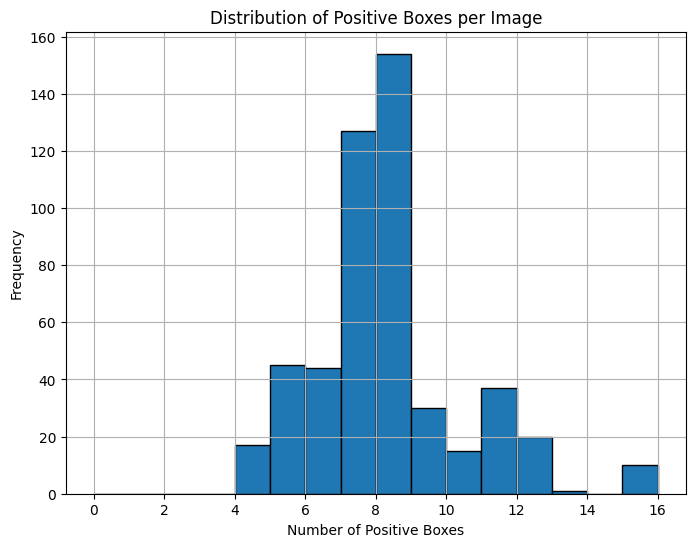

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_positive_boxes_distribution(encoded_boxes):
    """
    Plot the distribution of positive boxes per image.
    
    Args:
    - encoded_boxes: Tensor of shape (num_images, num_anchors, 5), where the 5th value indicates positive boxes.
    """
    # Convert tensor to numpy for easier manipulation
    encoded_boxes_np = encoded_boxes.numpy()
    
    # Get the positive box indicator
    positive_boxes = encoded_boxes_np[:, :,5]
    
    # Count how many positive boxes per image (sum along the anchor dimension)
    num_positive_boxes = np.sum(positive_boxes == 1, axis=1)
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.hist(num_positive_boxes, bins=np.arange(0, np.max(num_positive_boxes) + 1), edgecolor='black')
    plt.title('Distribution of Positive Boxes per Image')
    plt.xlabel('Number of Positive Boxes')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function with the encoded boxes
plot_positive_boxes_distribution(encoded)

### Class mapping with background class included

In [13]:
mnist_ssd_class_map = {
    0: 'background',
    1: 'digit_0',
    2: 'digit_1',
    3: 'digit_2',
    4: 'digit_3',
    5: 'digit_4',
    6: 'digit_5',
    7: 'digit_6',
    8: 'digit_7',
    9: 'digit_8',
    10: 'digit_9'
}

# Test anchors and encoding functions on dataset

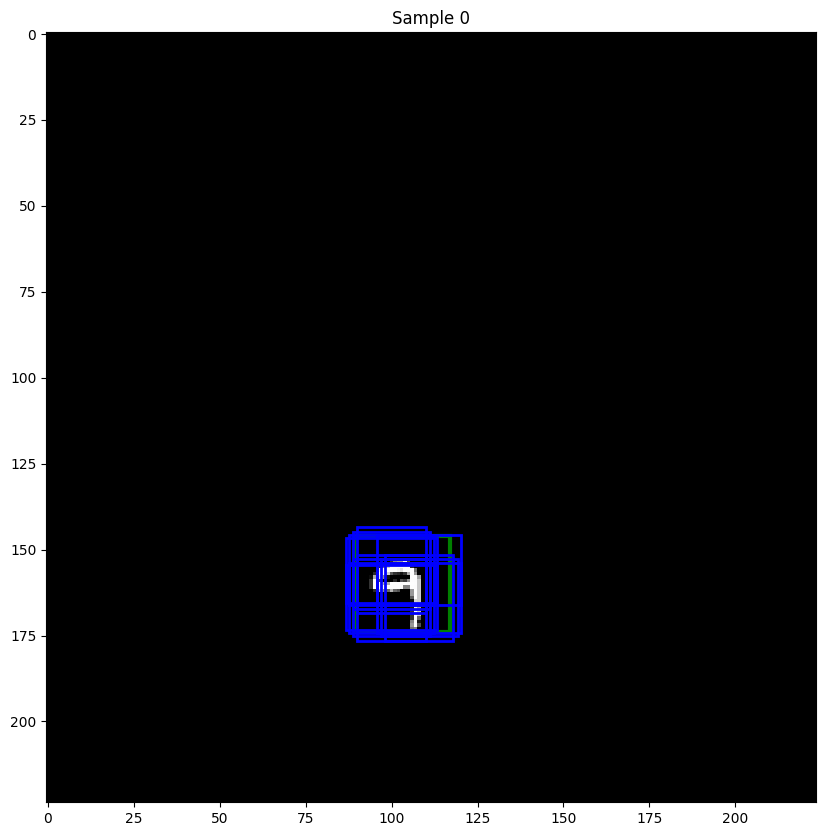

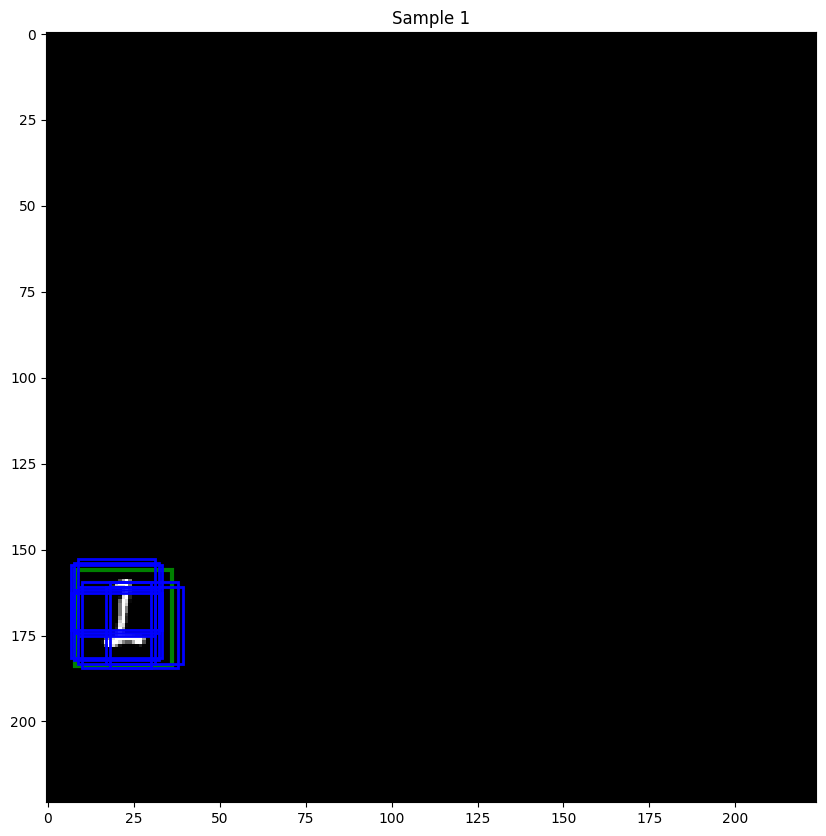

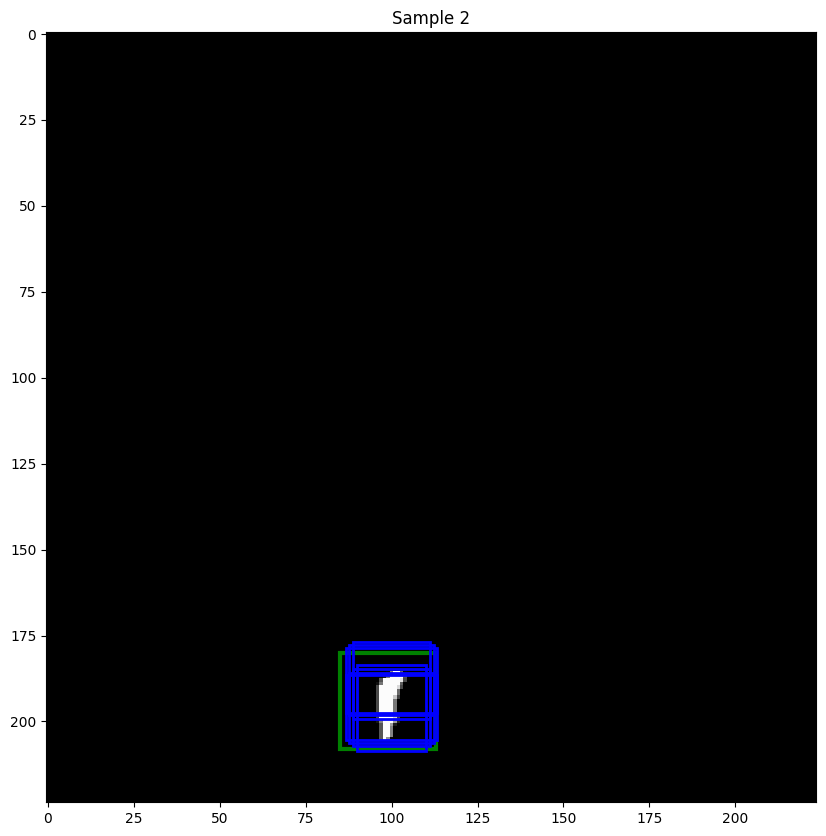

In [14]:
def decode_boxes(anchors, offsets, img_size = 224):
    """
    Apply offsets to anchors to get the decoded predicted bounding boxes.

    Args:
    - anchors: Tensor of shape (num_anchors, 4) with anchor boxes in center coordinates and sizes [cx, cy, w, h].
    - offsets: Tensor of shape (num_anchors, 4) with encoded offsets.
    - img_size: Target size for clipping to image borders

    Returns:
    - predicted_boxes: Tensor of shape (num_anchors, 4) with predicted boxes in corner coordinates [y1, x1, y2, x2].
    """
    # Unstack anchors and offsets
    anchor_cx, anchor_cy, anchor_w, anchor_h = tf.unstack(anchors, axis=-1)
    d_cx, d_cy, d_w, d_h = tf.unstack(offsets, axis=-1)

    # Apply offsets to get the predicted center coordinates and sizes
    pred_cx = anchor_cx + d_cx
    pred_cy = anchor_cy + d_cy
    pred_w = anchor_w + d_w
    pred_h = anchor_h + d_h

    # Convert from center coordinates and sizes to corner coordinates [y1, x1, y2, x2]
    pred_y1 = pred_cy - pred_h / 2
    pred_x1 = pred_cx - pred_w / 2
    pred_y2 = pred_cy + pred_h / 2
    pred_x2 = pred_cx + pred_w / 2

    decoded_boxes = tf.stack([pred_y1, pred_x1, pred_y2, pred_x2], axis=-1)
    
    return tf.clip_by_value(decoded_boxes, clip_value_min=0.0, clip_value_max=img_size)

def plot_encoded(images, anchors, encoded, gt_boxes, num_samples=5, plot_matching = False):
    """
    Plot the images with decoded bounding boxes.

    Args:
    - images: Tensor of shape (num_images, height, width, channels) representing the images.
    - anchors: Tensor of shape (num_anchors, 4) with anchor boxes in center coordinates and sizes [cx, cy, w, h].
    - encoded: Tensor of shape (num_images, num_anchors, 4) with encoded offsets.
    - gt_boxes: Tensor of shape (num_images, 4) with the actual gt boxes
    - num_samples: Number of samples to plot.
    - plot_matching: Plot only the raw matching anchors, instead of the decoded encodings
    """
    # Decode the boxes
    decoded_boxes = decode_boxes(anchors, encoded[:,:,1:5])
    
    # Convert to numpy arrays for plotting
    images = images.numpy()
    decoded_boxes = decoded_boxes.numpy()
    positives = encoded[:,:,5]
    class_labels = encoded[:, :, 0].numpy()


    for i in range(min(num_samples, images.shape[0])):
        img = images[i]
        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Get the boxes for the current image
        boxes = decoded_boxes[i]
        pos_indices = positives[i].numpy().astype(bool)  # Convert positives to boolean indices
        boxes = boxes[pos_indices]
        classes = class_labels[i][pos_indices]
        pos_achors = center2yx(anchors[pos_indices])

        ax = plt.gca()
        
        # Plot decoded box encodings if plot_matching anchors is not set
        if not plot_matching:
            print(f"Sample {i} - Number of positive boxes: {len(boxes)}")
                        
            for j, box in enumerate(boxes):
                y1, x1, y2, x2 = box

                if (y1 < 0 or x1 < 0 or y2 > img.shape[0] or x2 > img.shape[1]):
                    print(f"Warning: Box {j} is out of image bounds!")

                # Get the corresponding class label for this box
                class_index = int(classes[j])
                class_name = mnist_ssd_class_map.get(class_index, 'unknown')

                # Print the class of the box
                print(f"Box {j}: Class = {class_name}")
                
                # Create a rectangle patch
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                        linewidth=5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        # Plot ground truth boxes in green
        y1,x1,y2,x2 = center2yx(gt_boxes[i])
        
        # Create a rectangle patch for GT boxes
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                    linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        # Plot positive anchor matches
        if plot_matching:
            for j, anchor in enumerate(pos_achors):
                y1, x1, y2, x2 = anchor
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                        linewidth=2, edgecolor='b', facecolor='none')
                ax.add_patch(rect)

        plt.title(f'Sample {i}')
        plt.show()

# Example usage
anchors = tf.convert_to_tensor(load_anchors_as_tensor('anchors.txt'), dtype=tf.float32)
plot_encoded(imgs, anchors, encoded, gt_boxes, num_samples=3, plot_matching = True)